## Profiles

In [1]:
from neuron import h, rxd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

In [2]:
def wave_search(size, size_segments, time_period, times, au, Du):
    clear_output()
    # needed for standard run system
    h.load_file('stdrun.hoc')
    
    global dend
    
    dend = h.Section()
    dend.L = size
    dend.nseg = size_segments

    # WHERE the dynamics will take place
    where = rxd.Region(h.allsec())

    # WHO the actors are
    global u
    global z
    global v

    u = rxd.Species(where, d=Du, initial=0.5) #activator
    z = rxd.Species(where, d=20, initial=0.5) #inhibitor
    v = rxd.Species(where, d = 0, initial = (1/dend.L)*100) #modulator

    # HOW they act

    a = au;
    b = -0.4;
    c = 0.6;
    d = -0.8;
    u0 = 0.5;
    z0 = 0.5;
    av = 5.0;
    kz = 0.001;

    bistable_reaction1 = rxd.Rate(u, (a * (u - u0) + b * (z - z0) - av * (u - u0) ** 3) * (v ** -2))
    bistable_reaction2 = rxd.Rate(z, (c * (u - u0) + d * (z - z0)) * (v ** -2))

    # initial conditions 
    h.finitialize()
    for node in u.nodes:
        if node.x < .2: node.concentration = 0.6
        if node.x > .8: node.concentration = 0.6
    for node in z.nodes:
        if node.x < .2: node.concentration = 0.6
        if node.x > .8: node.concentration = 0.6

    #Setting up time frame
    global u_timespace
    
    T_d = times
    T = time_period
    u_timespace = []

    for i in xrange(1, T_d):
        h.continuerun(i * T)
        u_timespace.append(u.nodes.concentration)
    
#activator FFT source files
    u_fft_y = u.nodes.concentration
    u_fft_y = u_fft_y - np.mean(u_fft_y)
    u_fft_x = u.nodes.x
    global u_fft_x_norm
    u_fft_x_norm = dend.L * np.array(u_fft_x)

    #inhibitor FFT source files
    z_fft_y = z.nodes.concentration
    z_fft_y = z_fft_y - np.mean(z_fft_y)
    z_fft_x = z.nodes.x
    z_fft_x_norm = dend.L * np.array(u_fft_x)

    #activator FFT
    Y1 = np.fft.fft(u_fft_y)
    N = len(Y1)/2+1
    dt = dend.L/dend.nseg
    fa = 1.0/dt
    X = np.linspace(0, fa/2, N, endpoint=True)

    #inhibitor FFT
    Y2 = np.fft.fft(z_fft_y)
    X2 = np.linspace(0, fa/2, N, endpoint=True)


    if (len(X) == len(2.0*np.abs(Y1[:N]/N))):
        u_maxx = (np.argmax(2.0*np.abs(Y1[:N]/N)))
        wavelen = np.around(1/X[u_maxx])
        
    return wavelen

## Ploting

In [3]:
def plot_it():
    clear_output()
    #Activator plt
    y1 = u.nodes.concentration
    x1 = u.nodes.x

    # convert x from normalized position to microns
    x1 = dend.L * np.array(x1)
    
    plt.figure(figsize=(20,10))
    plt.subplot(221)
    plt.title('Activator profile')
    plt.xlabel('System size')
    plt.ylabel('Concentration')
    plt.plot(x1, y1, '-b')
    
    #Inhibitor plt
    y2 = z.nodes.concentration
    x2 = z.nodes.x

    # convert x from normalized position to microns
    x2 = dend.L * np.array(x2)
    
    plt.subplot(222)
    plt.title('Inhibitor profile')
    plt.xlabel('System size')
    plt.ylabel('Concentration')
    plt.plot(x2, y2, '-r')
    
    #Modulator plt
    y3 = v.nodes.concentration
    x3 = v.nodes.x
    
    # convert x from normalized position to microns
    x3 = dend.L * np.array(x3)
    
    plt.subplot(223)
    plt.title('Modulator profile')
    plt.xlabel('System size')
    plt.ylabel('Concentration')
    plt.plot(x3, y3, '-g')

## Main code

In [4]:
import time
start_time1 = time.time()

wl_table = []
a_u = 0.18 # activator kinetic constant
D_u = 1
time_period = 50
times = 20

for i in xrange(60, 65, 5):
    wl = wave_search(i, 2 * i, time_period, times, a_u, D_u)
#     j = round(j,2)
    wl_table.append([i, 2 * i, time_period, times, a_u, D_u, wl])
    print(wl_table)
print(wl_table)

print "It took", time.time() - start_time1, "to run whole code"

[[60, 120, 50, 20, 0.18, 1, 30.0]]
[[60, 120, 50, 20, 0.18, 1, 30.0]]
It took 55.9699749947 to run whole code



## Writing output to file

In [5]:
import csv

with open("output.csv", "wb") as f:
    writer = csv.writer(f);
    writer.writerows(wl_table)

## Plots 

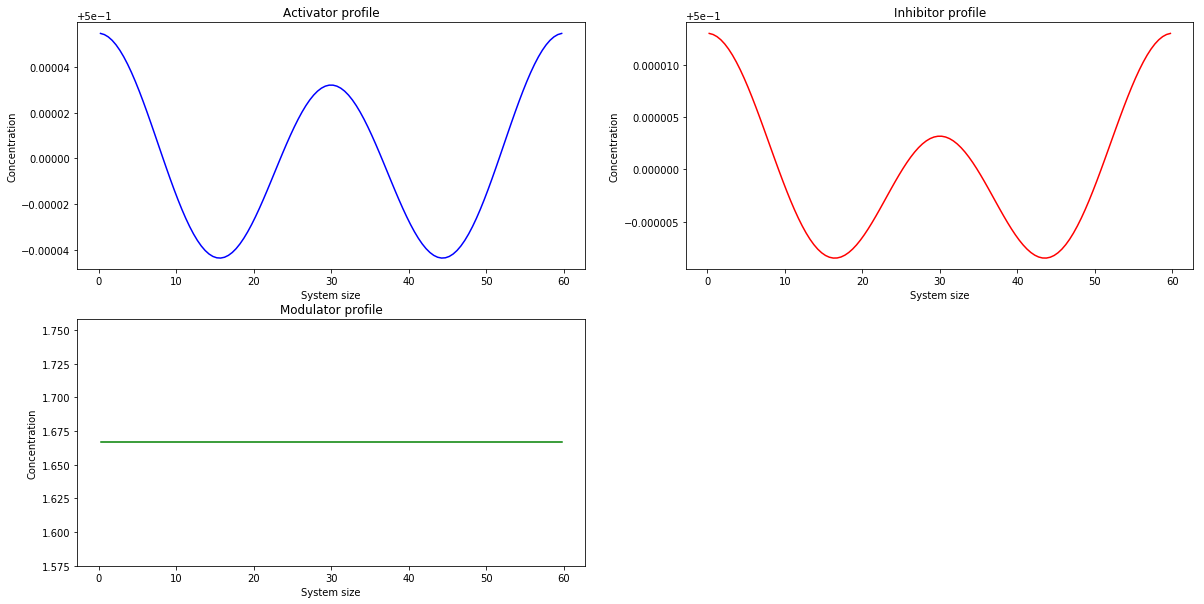

In [6]:
#Plot the last time step result
    
plot_it()

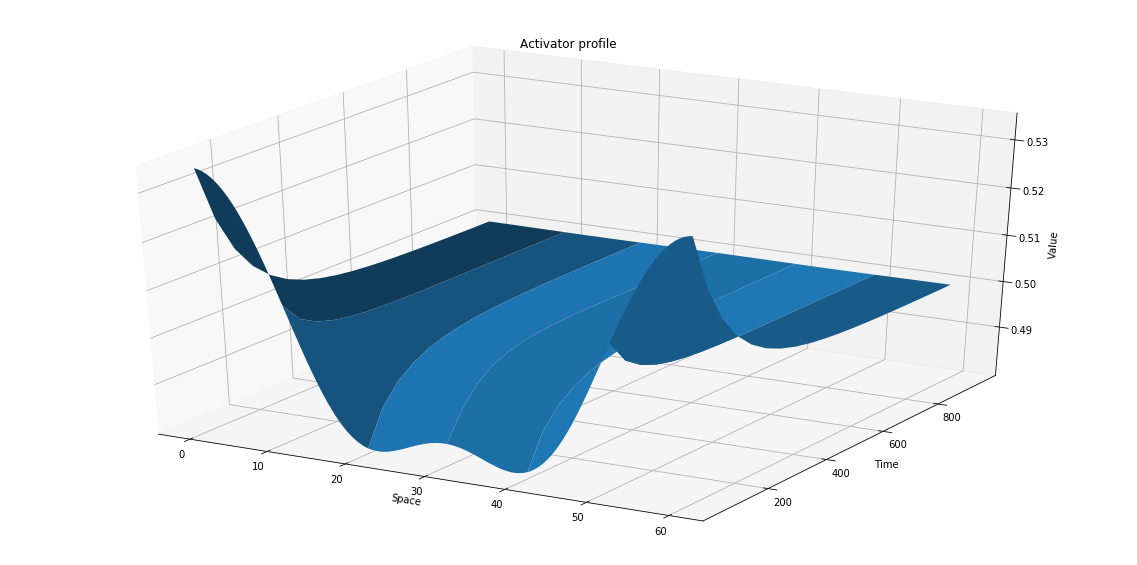

In [7]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize=(20,10)) # Make a new figure window
ax = fig.add_subplot(111, projection='3d')

# Grab data.
xx = u_fft_x_norm
yy = [i*time_period for i in xrange(1, times)]
zz = u_timespace

XX, YY = np.meshgrid(xx, yy)
ZZ = zz

# Plot a basic wireframe.
ax.plot_surface(XX, YY, ZZ, rstride=20, cstride=20)
ax.set_xlabel('Space')
ax.set_ylabel('Time')
ax.set_zlabel('Value')
ax.set_title('Activator profile')

plt.show()

In [8]:
#FFT results show

plt.figure(figsize=(20,10)) #figsize w,h tuple in inches
plt.subplot(221)
plt.plot(u_fft_x_norm,u_fft_y,'-b')
plt.xlabel('System size')
plt.ylabel('Amplitude - Mean')
plt.title('Activator profile')

plt.subplot(222)
plt.plot(X, 2.0*np.abs(Y1[:N]/N),'-o')
plt.xlabel('Freq (Hz)')
plt.ylabel('|Y(freq)|')
plt.title('Frequency domain')

plt.subplot(223)
plt.plot(z_fft_x_norm,z_fft_y,'-r')
plt.xlabel('System size')
plt.ylabel('Amplitude - Mean')
plt.title('Inhibitor profile')

plt.subplot(224)
plt.plot(X2, 2.0*np.abs(Y2[:N]/N),'-o')
plt.xlabel('Freq (Hz)')
plt.ylabel('|Y(freq)|')
plt.title('Frequency domain')


plt.show()

In [9]:
# clear_output()
# import subprocess
# subprocess.call(['osascript', '-e', 'tell application "XQuartz" to quit'])